# **Данный ноутбук является результатом практического задания по KNN за 3 крус осеннний семестр, выполненного студентом кафедры ММП Московского Государственного Университета Федоровым Артемом Максимовичем**

### Задачей было запрограммировать библиотеку с модулями knn, кроссвалидации и дистанциями, чтобы затем провести ряд экспериментов по улучшению классического knn на основе результатов классификации датасета mnist784

# Подготовим рабочую среду

Для начала установим все нужные для начала библиотеки и загрузим сам датасет.
Для этого воспользуемся готовым решением на базе skylearn

In [2]:
!pip install dill

In [4]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill

np.random.seed(666)  # адский сатана

Теперь загрузим сам датасет через sklearn.datasets.fetch_openml и посмотрим на его устройство

In [5]:
mnist = fetch_openml('mnist_784', parser='pandas')

И сразу же переведем его в формат numpy

In [6]:
imgs = mnist.data.to_numpy()
target = mnist.target.to_numpy()

Выведем несколько примерров тех цифр, что присутсвуют в датасете.

# Посмотрим на данные

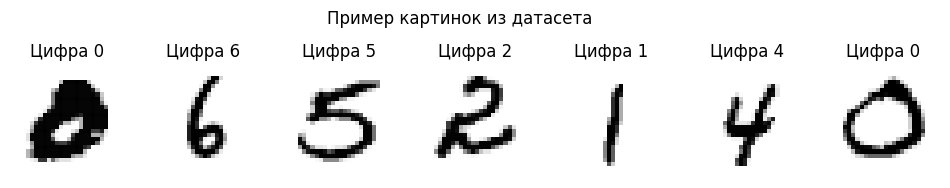

In [26]:
rands = np.random.randint(mnist.data.shape[0], size=7)
fig, axes = plt.subplots(1, 7)
fig.suptitle('Пример картинок из датасета')
fig.set_figheight(2.3)
fig.set_figwidth(12)
for i, loc in enumerate(rands):
    axes[i].set_title(f'Цифра {target[loc]}')
    axes[i].imshow(imgs[loc].reshape((28, 28)), cmap='Greys')
    axes[i].axis("off")
# fig

Посмтрим на пространство объектов

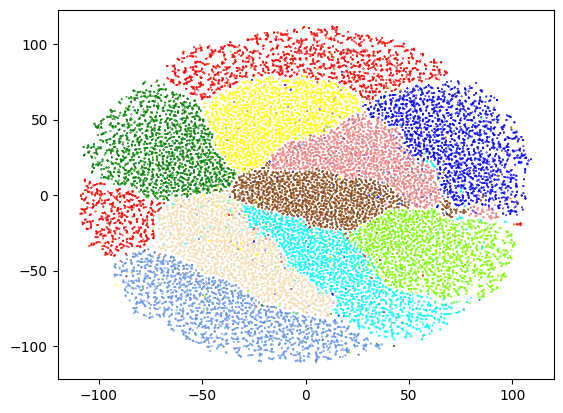

In [19]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(imgs[:50000])
colors = []
for t in target[:50000]:
  color = {
      '0': 'green',
      '1': 'red',
      '2': 'yellow',
      '3': 'blue',
      '4': 'lawngreen',
      '5': 'lightcoral',
      '6': 'cornflowerblue',
      '7': 'wheat',
      '8': 'saddlebrown',
      '9': 'aqua'
  }
  colors.append(color[t])



plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=0.05)

# Реализация модуля distances

Теперь же давайте построим алгоритмы для построения матриц расстояний между объектами.

Мы имеем соедующее: $X^\ell$ - обучающая выборка $\Re^{\ell𝗑782}$, где $\ell$ фактически мощость множества обучающей выборки (в нашем случае 60000). Для тестовой выборки $Y^\mu$ из $\Re^{\mu𝗑782}$ с μ равной 10000 мы хотим получить такую матрицу расстояний $r=\Re^{\mu𝗑\ell}$, что отражала бы попарные расстояния между обектом из тестовой выборки и каждым из обучающей

Для нормы матрицы Фробениуса:

$N_{ij}=\sqrt{\sum_{k=1}^{784}{(Y_{ik} - X_{kj})^2}} = \sqrt{\sum_{k=1}^{784}Y_{ik}^2 + \sum_{k=1}^{784}X_{kj}^2 - 2YX^τ}$

In [7]:
def euclidean_distance(Y: np.ndarray, X: np.ndarray) -> np.ndarray:
  return ((Y ** 2).sum(axis=1)[:, None] + (X ** 2).sum(axis=1).T[None, :] - 2 * Y @ X.T) ** 0.5

Для косинусной метрики

$N_{ij}=1 - \frac{\sum_{k=1}^{784}{Y_{ik}X_{kj}}}{\sqrt{\sum_{k=1}^{784}{Y_{ik}^2}}{\sqrt{\sum_{k=1}^{784}{X_{kj}^2}}}}$

In [8]:
def cosine_distance(Y: np.ndarray, X: np.ndarray) -> np.ndarray:
  return 1 - ((Y @ X.T) / np.sqrt((Y ** 2).sum(axis=1).reshape((-1, 1)) @ (X ** 2).sum(axis=1).reshape((1, -1))))

# Реализация модуля nearest-neighbous

Реализуем класс KNNClassifier

In [9]:
class _MY_OWN_NEIGHBOURS():
    __slots__ = ('k', 'metric', 'matrix', 'test_block_size')

    def __init__(self, n_neighbors, metric, test_block_size):
      self.k = n_neighbors
      self.metric = euclidean_distance if metric == 'euclidean' else cosine_distance
      self.test_block_size = test_block_size

    def fit(self, X):
      self.matrix = X
      return self

    def kneighbors(self, X, return_distance):
      dists = self.metric(X, self.matrix)
      indexes = np.argpartition(dists, self.k)[:, :self.k]

      k_dists = np.take_along_axis(dists, indexes, axis=1)
      k_dists_indexes = np.argsort(k_dists)
      k_indexes = np.take_along_axis(indexes,k_dists_indexes, axis=1)

      return (
          np.take_along_axis(k_dists, k_dists_indexes, axis=1),
          k_indexes
      ) if return_distance else k_indexes

In [10]:
def KNN_type_checker(func):
  def inner(self, k: int, strategy: str, metric: str, weights: bool, test_block_size: int):
    if not isinstance(k, int):
      raise TypeError('k must be int')
    if strategy not in ['my_own', 'brute', 'kd_tree', 'ball_tree']:
      raise TypeError('not valid name of strategy')
    if metric not in ['euclidean', 'cosine']:
      raise TypeError('not valid name of metric')
    if not isinstance(weights, bool):
      raise TypeError('weights must be a boolean')
    if not isinstance(test_block_size, int) and test_block_size is not None:
      raise TypeError('test_block_size must be integer or None')
    if strategy in ['kd_tree', 'ball_tree'] and metric == 'cosine':
      raise TypeError('Cosine can not be used with such strategy')
    func(self, k=k, strategy=strategy, metric=metric, weights=weights, test_block_size=test_block_size)

  return inner

In [11]:
from collections import defaultdict
from sklearn.metrics.pairwise import distance
from sklearn.neighbors import NearestNeighbors

class KNNClassifier():
    __slots__ = ('k', 'strategy', 'metric', 'weights', 'test_block_size', 'target')

    @KNN_type_checker
    def __init__(self, k: int, strategy: str, metric: str, weights: bool, test_block_size: int):
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size

        if strategy in ['brute', 'kd_tree', 'ball_tree']:
            self.strategy = NearestNeighbors(n_neighbors=k, metric=metric, algorithm=strategy)
        else:
            self.strategy = _MY_OWN_NEIGHBOURS(n_neighbors=k, metric=metric, test_block_size=test_block_size)

    def fit(self, X: np.ndarray, y):
        self.target = y
        self.strategy.fit(X)

        return self

    def find_kneighbors(self, X, return_distance):

        def _get_parts(self, Y):
            if self.test_block_size is None:
                yield Y
            else:
                for block_index in range(int(Y.shape[0] / self.test_block_size) + 1):
                    yield Y[self.test_block_size * block_index: self.test_block_size * (block_index + 1)]

        answ = []
        answ_dist = []

        for part in _get_parts(self, X):
            if len(part) == 0:
                break

            if return_distance:
                temp_dist, temp_answ = self.strategy.kneighbors(part, return_distance=return_distance)
                answ_dist.append(temp_dist)
                answ.append(temp_answ)
            else:
                answ.append(self.strategy.kneighbors(part, return_distance=return_distance))

        if return_distance:
            return np.vstack(answ_dist), np.vstack(answ)
        else:
            return np.vstack(answ)

    def predict(self, X: np.ndarray, *, _k=None, _dists=None, _indexes=None):

        def _find_best_match(weights, indexes):
            buckets = defaultdict(lambda: 0)
            for i, ind in enumerate(indexes):
                buckets[self.target[ind]] += weights[i]
            return max(buckets, key=buckets.get)

        if _k is not None or _dists is not None or _indexes is not None:
            if _k is None or _dists is None or _indexes is None:
                raise TypeError("all 3 aprams k, dists, indx must be None or not None")
            else:
                answ = []
                for _dist, _indx in zip(_dists, _indexes):
                    answ.append(_find_best_match(_dist, _indx))
                return answ

        if self.weights:
            dists, indexes = self.find_kneighbors(X, True)
            answ = []
            for dist, indx in zip(dists, indexes):
                answ.append(_find_best_match(1 / (np.sort(dist) + 1E-5), indx))
            return answ
        else:
            indexes = self.find_kneighbors(X, False)
            answ = []
            for indx in indexes:
                answ.append(_find_best_match(np.ones(indx.shape), indx))
            return answ


# Реализация модуля cross_validation

In [12]:
import numpy as np


def kfold(n: int, n_folds: int):
    k = [n // n_folds + 1 if i < n % n_folds else n // n_folds for i in range(n_folds)]
    answ = []
    for i in range(len(k)):
        test_bool = np.hstack([np.full((r), False) if ind != i else np.full((r), True) for ind, r in enumerate(k)])
        test = np.where(test_bool)[0]
        train = np.where(np.logical_not(test_bool))[0]
        answ.append((train, test))
    return answ

In [13]:
def CV_type_checker(func):
    def inner(X, y, k_list, score, cv, **kwargs):
        if 'k' in kwargs.keys():
            raise TypeError('k передается через лист k_list')
        if not isinstance(k_list, list):
            raise TypeError('k_list должен быть листом количества соседей')
        if not isinstance(score, str):
            raise TypeError('score должна быть строкой')
        if score not in ['accuracy']:
            raise TypeError('score указана не верно')
        answ = func(X, y, k_list, score, cv, **kwargs)
        return answ
    return inner

In [14]:
from collections import defaultdict

@CV_type_checker
def knn_cross_val_score(X, y, k_list, score, cv=None, **kwargs):

    def _accuracy(pred, ground):
        return np.sum(pred == ground) / len(pred)

    if cv is None:
        cv = kfold(len(X), int(5))

    k_scoring = defaultdict(lambda: [])
    k_max = sorted(k_list, reverse=True)[0]
    knn = KNNClassifier(**kwargs, k=k_max)

    for train_idx, test_idx in cv:
      model = knn.fit(X[train_idx], y[train_idx]).fit(X[train_idx], y[train_idx])
      dist, indexes = model.find_kneighbors(X[test_idx], True)

      for k in sorted(k_list):
        y_pred = model.predict(X[test_idx], _k=k, _dists=dist[:, :k], _indexes=indexes[:, :k])
        k_scoring[k].append(_accuracy(y_pred, y[test_idx]))

    return dict(k_scoring)

# Эксперименты

## **Эксперимент №1.**

Разобьем нашу выборку на обучающую и валидационную как 6:1

In [15]:
x_train, x_test = imgs[:60000], imgs[60000:]
y_train, y_test = target[:60000], target[:60000]

Создадим четыре версии класса KNNClassifier по одному для каждой стратегии поиска ближайших соседей: выставим поиск по 5 ближайшим без учета весов расстояний по евклидовой метрике. Для этого создадим список из 4 кортежей, каждый из которых состоит из имени алгоритма и самого объекта

In [ ]:
knns = [(st_type, KNNClassifier(k=5, strategy=st_type, metric='euclidean', weights=False, test_block_size=None)) \
  for st_type in ['my_own', 'brute', 'kd_tree', 'ball_tree']]

Создадим список из подмножеств признаков, по которым будет считаться расстояние **(размеров 10, 20, 100)**

In [ ]:
results_times = []

In [ ]:
import time
features = [np.random.randint(x_train.shape[1], size=size) for size in [10, 20, 100]]

for ft in features:
  X_tr = x_train[:, ft]
  Y_tr = y_train

  X_ts = x_test[:, ft]


  for st_type, knn in knns:
    start_fit = time.time()
    model = knn.fit(X_tr, Y_tr)
    delta_fit = time.time() - start_fit

    start_predict = time.time()
    model.predict(X_ts)
    delta_predict = time.time() - start_predict

    results_times.append({
        'model' : st_type,
        'fearures' : len(ft),
        'delta_fit' : delta_fit,
        'delta_predict' : delta_predict
    })

In [ ]:
results_times

[{'model': 'my_own',
  'fearures': 10,
  'delta_fit': 1.0013580322265625e-05,
  'delta_predict': 23.932798147201538},
 {'model': 'brute',
  'fearures': 10,
  'delta_fit': 0.07601714134216309,
  'delta_predict': 1.6000676155090332},
 {'model': 'kd_tree',
  'fearures': 10,
  'delta_fit': 0.07990336418151855,
  'delta_predict': 1.6401176452636719},
 {'model': 'ball_tree',
  'fearures': 10,
  'delta_fit': 0.06973981857299805,
  'delta_predict': 1.5817296504974365},
 {'model': 'my_own',
  'fearures': 20,
  'delta_fit': 9.298324584960938e-06,
  'delta_predict': 29.968547821044922},
 {'model': 'brute',
  'fearures': 20,
  'delta_fit': 0.002311229705810547,
  'delta_predict': 9.012494802474976},
 {'model': 'kd_tree',
  'fearures': 20,
  'delta_fit': 0.0017414093017578125,
  'delta_predict': 9.120082139968872},
 {'model': 'ball_tree',
  'fearures': 20,
  'delta_fit': 0.001764535903930664,
  'delta_predict': 9.041600465774536},
 {'model': 'my_own',
  'fearures': 100,
  'delta_fit': 1.12056732177

## **Эксперимент №2.**

Оценим зависимость точности алгоритма KNN при стратегии brute с помощью кроссвалидации по трем фолдам на всей выборке от параметра k, где k -- число ближайших соседей, вносящих свой вклад в классификацию. Будем использовать не взвешенный метод

Испытаем на двух метриках

In [ ]:
x_train = imgs
y_train = target

In [ ]:
x_train.shape

(70000, 784)

In [ ]:
results_metrics = {}

In [ ]:
for metric in ['cosine', 'euclidean']:
  results_metrics[metric] = knn_cross_val_score(x_train, y_train, [*range(1, 11)], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric=metric, weights=False, test_block_size=None)

Построим метрики для полученных значений. Так как на каждом фолде могут полуиться разные значения, имеет значение посмотреть усредненный score а так же его максимальное значение и минимальное на каждом фолде (посмотреть на размах значения)

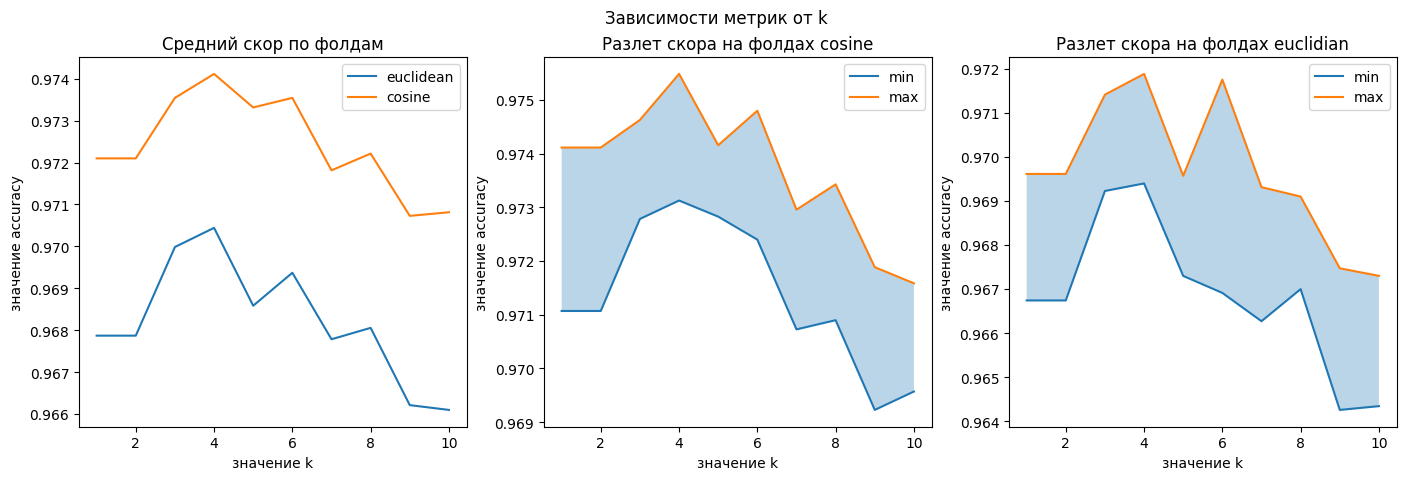

In [ ]:
df = pd.DataFrame(results_metrics)
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Зависимости метрик от k')
axes[0].set_title('Средний скор по фолдам')
axes[0].set_xlabel('значение k')
axes[0].set_ylabel('значение accuracy')
axes[0].plot(df.euclidean.apply(lambda x: sum(x) / len(x)), label='euclidean')
axes[0].plot(df.cosine.apply(lambda x: sum(x) / len(x)), label='cosine')
axes[0].legend()

axes[1].set_title('Разлет скора на фолдах cosine')
axes[1].set_xlabel('значение k')
axes[1].set_ylabel('значение accuracy')
axes[1].plot(df.cosine.apply(lambda x: min(x)), label='min')
axes[1].plot(df.cosine.apply(lambda x: max(x)), label='max')
axes[1].fill_between(df.index, df.cosine.apply(lambda x: max(x)), df.cosine.apply(lambda x: min(x)), interpolate=True, alpha=0.3)
axes[1].legend()

axes[2].set_title('Разлет скора на фолдах euclidian')
axes[2].set_xlabel('значение k')
axes[2].set_ylabel('значение accuracy')
axes[2].plot(df.euclidean.apply(lambda x: min(x)), label='min')
axes[2].plot(df.euclidean.apply(lambda x: max(x)), label='max')
axes[2].fill_between(df.index, df.euclidean.apply(lambda x: max(x)), df.euclidean.apply(lambda x: min(x)), interpolate=True, alpha=0.3)
axes[2].legend()

## **Эксперимент №3.**

Теперь сравним два подхода к определению алгоритма ближайших соседей. С первым, без весовым, мы уже успели поработать, теперь давайте посмотрим, как себя ведет алгоритм с весами, выражающимися как монотонно убывающая функция от расстояния

In [ ]:
x_train = imgs
y_train = target

In [ ]:
results_weights = {
    'weighted' : [],
    'unweighted' : []
}

Из прошлых экспериментов у нас уже может родиться предположение о роли весов в классификации путем KNN. Качество работы классификации падает с ростом количества соседей. Это происходит из-за того, что любой объект попадает к нам с одинаковым вкладом в итоговый ответ. Возможно, если мы будем учитывать степень схожести, мы сможем исправить эту ситуацию

In [ ]:
results_weights['weighted'] = knn_cross_val_score(x_train, y_train, [1, 2, 10, 30, 100, 150, 300], 'accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=None)
results_weights['unweighted'] = knn_cross_val_score(x_train, y_train, [1, 2, 10, 30, 100, 150, 300], 'accuracy', cv=None, strategy='brute', metric='cosine', weights=False, test_block_size=None)

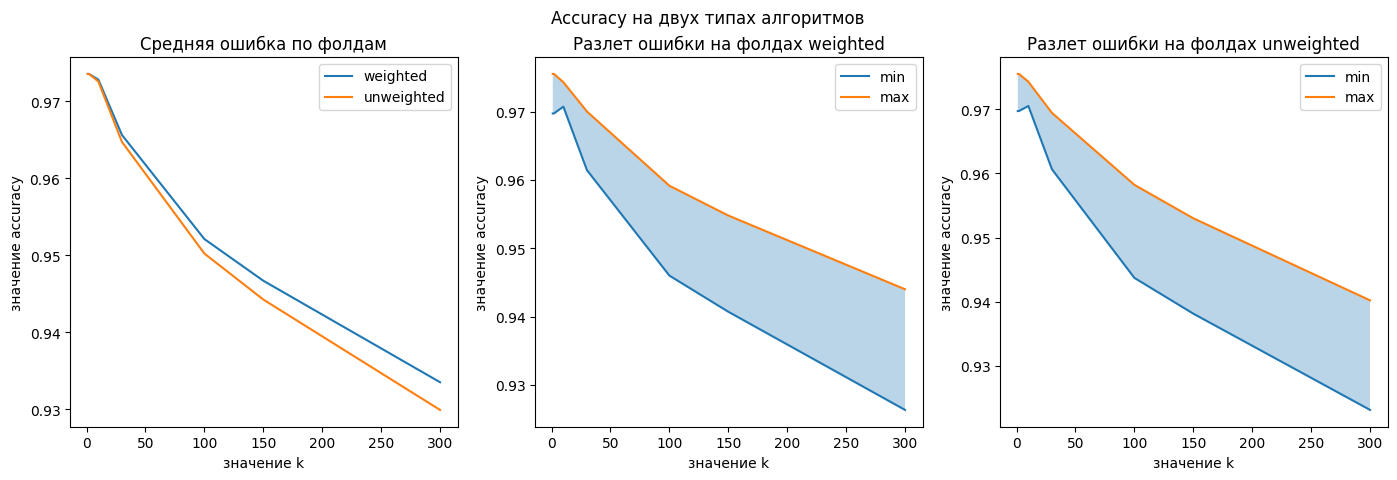

In [ ]:
df = pd.DataFrame(results_weights)
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Accuracy на двух типах алгоритмов')
axes[0].set_title('Средняя ошибка по фолдам')
axes[0].set_xlabel('значение k')
axes[0].set_ylabel('значение accuracy')
axes[0].plot(df.weighted.apply(lambda x: sum(x) / len(x)), label='weighted')
axes[0].plot(df.unweighted.apply(lambda x: sum(x) / len(x)), label='unweighted')
axes[0].legend()

axes[1].set_title('Разлет ошибки на фолдах weighted')
axes[1].set_xlabel('значение k')
axes[1].set_ylabel('значение accuracy')
axes[1].plot(df.weighted.apply(lambda x: min(x)), label='min')
axes[1].plot(df.weighted.apply(lambda x: max(x)), label='max')
axes[1].fill_between(df.index, df.weighted.apply(lambda x: max(x)), df.weighted.apply(lambda x: min(x)), interpolate=True, alpha=0.3)
axes[1].legend()

axes[2].set_title('Разлет ошибки на фолдах unweighted')
axes[2].set_xlabel('значение k')
axes[2].set_ylabel('значение accuracy')
axes[2].plot(df.unweighted.apply(lambda x: min(x)), label='min')
axes[2].plot(df.unweighted.apply(lambda x: max(x)), label='max')
axes[2].fill_between(df.index, df.unweighted.apply(lambda x: max(x)), df.unweighted.apply(lambda x: min(x)), interpolate=True, alpha=0.3)
axes[2].legend()

## **Эксперимент №4.**

Получим предсказания для лучше получившейся у нас моделли на выборках 6:1, сравним ее accuracy с показателем на крос валидации по 5 фолдам и построим матрицу ошибок

Разобьем выборку и создадим модель

In [ ]:
x_train, x_test = imgs[:60000], imgs[60000:]
y_train, y_test = target[:60000], target[60000:]
knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=None)

Получим предсказание на модели knn с косинусным расстоянием, k равным 4 и с включенными весами. То же самое сделаем для кроссвалидации

In [ ]:
import statistics
y_pred = knn.fit(x_train, y_train).predict(x_test)
simple_knn_accuracy = np.sum([a == b for a,b in zip(y_pred, y_test)]) / len(y_pred)
cross_validate_accuracy = statistics.mean(knn_cross_val_score(imgs, target, [4], 'accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

In [ ]:
print(f'Accuracy CCV -> {cross_validate_accuracy}')
print(f'Accuracy knn -> { simple_knn_accuracy}')

Accuracy CCV -> 0.9759
Accuracy knn -> 0.9752


Можно увидеть, что мы получили примерно одинаковые значения, находящиеся примерно в значении 0.975. Давайте сравним такой результат с наилучшим результатом в интренете.

На официальном лидер-борде по mnist можно увидеть следующие точности:


> K-NN with non-linear deformation (IDM) -> 0.54% ошибок или же 0.9946 Accuracy

> K-NN, Tangent Distance -> 1.1% ошибок или же 0.989 Accuracy

> K-NN, shape context matching -> 0.63% ошибок или же 0,9937 Accuracy







Построим матрицу ошибок и посмотрим, какие классы чаще всего между собой путаются

In [ ]:
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
print(tabulate([[i, *confusion_matrix(y_pred, y_test)[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

|    |   0 |    1 |    2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|----+-----+------+------+-----+-----+-----+-----+-----+-----+-----|
|  0 | 977 |    0 |    8 |   0 |   2 |   4 |   3 |   2 |   7 |   7 |
|  1 |   1 | 1129 |    0 |   1 |   1 |   0 |   3 |  10 |   1 |   7 |
|  2 |   0 |    3 | 1009 |   3 |   0 |   0 |   0 |   4 |   2 |   2 |
|  3 |   0 |    1 |    1 | 976 |   0 |   9 |   0 |   0 |   9 |   5 |
|  4 |   0 |    0 |    1 |   1 | 946 |   1 |   1 |   1 |   3 |   7 |
|  5 |   0 |    0 |    0 |  12 |   0 | 863 |   3 |   0 |   3 |   3 |
|  6 |   1 |    2 |    0 |   0 |   6 |   7 | 948 |   0 |   5 |   1 |
|  7 |   1 |    0 |    8 |   4 |   2 |   1 |   0 | 998 |   4 |   4 |
|  8 |   0 |    0 |    5 |   9 |   0 |   4 |   0 |   0 | 936 |   3 |
|  9 |   0 |    0 |    0 |   4 |  25 |   3 |   0 |  13 |   4 | 970 |



Чаще всего, как можно заметить, ошибки происходили из-за того, что ноль отнесли к 2, 8 и 9, единицу отнесли к 7, тройку к 8, четверку к 9, пять к трем, девять к 4 и 7

При чем самые большие ошибки происходят именно из-за ошибок 5->3, 9->[4, 7], 1->7

**Посмотрим на те объекты, что вызывают проблемы**

In [ ]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)

indexes = np.where((y_test != y_pred) & (((y_test == '5') & (y_pred == '3')) | ((((y_test == '4') | (y_test == '7')) & (y_pred == '9'))) | ((y_test == '7') & (y_pred == '1'))))

In [ ]:
object_indexes = np.where((y_test != y_pred))[0][np.random.randint(30, size=21)]

In [ ]:
images = {'vectors': x_test[object_indexes], 'ground': y_test[object_indexes], 'prediction': y_pred[object_indexes]}

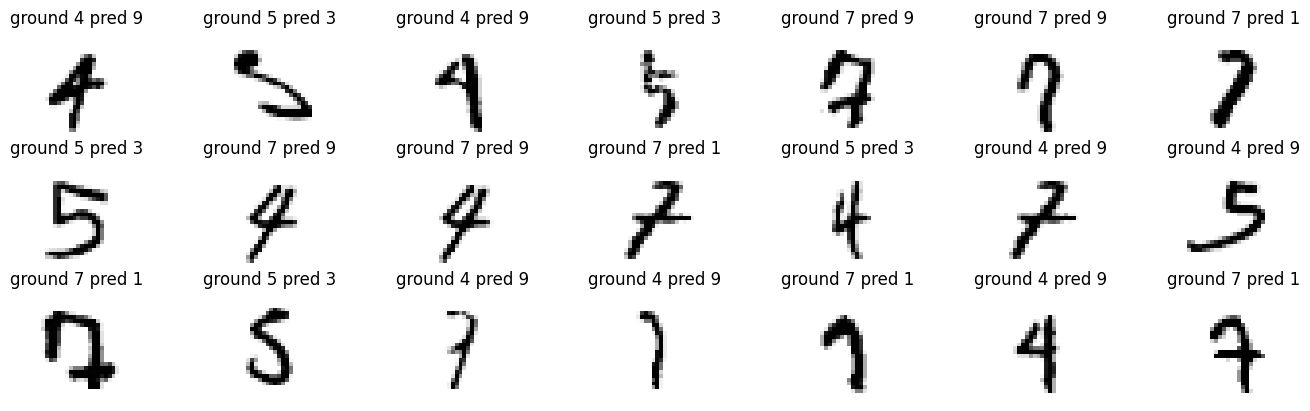

In [ ]:
figure, axes = plt.subplots(3, 7)
figure.set_figwidth(17)
for i in range(3):
  for j in range(7):
    axes[i][j].imshow(images['vectors'][i * 7 + j].reshape(28, 28), cmap="Greys")
    axes[i][j].axis("off")
    axes[i][j].set_title(f"ground {images['ground'][i * 3 + j]} pred {images['prediction'][i * 3 + j]}")

## **Эксперимент №5 и №6.**

Выполним аугментацию данных. Для этого установим open CV

In [17]:
from scipy import ndimage

In [15]:
x_train, x_test = imgs[:60000], imgs[60000:]
y_train, y_test = target[:60000], target[60000:]

# x_train.dump('/content/drive/MyDrive/Colab Notebooks/KNN_prac/vanilla_train')

Образуем новые выборки, что будут представлены 6 датасетами, образованными из начальной выборки **поворотм** каждой из картинок на 5, 10 и 15 градусов в каждую из сторон

In [ ]:
for i in [5, 10, 15]:
  ndimage.rotate(x_train.reshape((-1, 28, 28)), i, axes=(1, 2), reshape=False).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/rotated_{i}')
  ndimage.rotate(x_train.reshape((-1, 28, 28)), -i, axes=(1, 2), reshape=False).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/rotated_{-i}')

Теперь проведем **смещения** картинок по каждой из осей в обе стороны на 1, 2, 3 пикселей

In [ ]:
for i in [1, 2, 3]:
  ndimage.shift(x_train.reshape((-1, 28, 28)), shift=[0, i, 0]).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_vert_{i}')
  ndimage.shift(x_train.reshape((-1, 28, 28)), shift=[0, -i, 0]).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_vert_{-i}')
  ndimage.shift(x_train.reshape((-1, 28, 28)), shift=[0, 0, i]).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_hor_{i}')
  ndimage.shift(x_train.reshape((-1, 28, 28)), shift=[0, 0, -i]).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_hor_{-i}')

Теперь применим **фильр Гаусса** с ядром в 0.5, 1, 1.5

In [ ]:
for i in [0.5, 1, 1.5]:
  ndimage.gaussian_filter(x_train.reshape((-1, 28, 28)), sigma=[0, i, i]).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/gaus_{i}')

Импортируем библиотеку Open CV

In [18]:
!pip install opencv-python
import cv2

Применим **эрозию**. Изображения настолько маленькие, что при выборе большого ядра изображение в принципе теряет свои начальные очертания. Потому применим фильтр 2 на 2

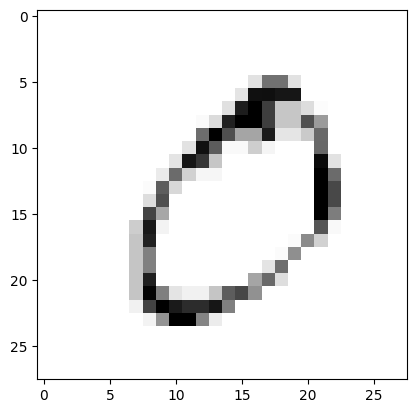

In [ ]:
imgs = (x_train.reshape((-1, 28, 28))).astype(np.uint8)
kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(imgs[1], kernel, iterations=1)
plt.imshow(erosion, cmap="Greys")

In [ ]:
kernel = np.ones((2,2),np.uint8)
erode = lambda x: cv2.erode(x.reshape((28, 28)), kernel, iterations=1)
np.apply_along_axis(erode, 1, x_train.astype(np.uint8)).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/erosion')

Убрав границы, попробуем пойти в противоположном направлении. Применим **дилатация**

In [ ]:
kernel = np.ones((2,2),np.uint8)
dilate = lambda x: cv2.dilate(x.reshape((28, 28)), kernel, iterations=1)
np.apply_along_axis(dilate, 1, x_train.astype(np.uint8)).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/dilation')

Теперь применим **открытие** к выборке

In [ ]:
kernel = np.ones((2,2),np.uint8)
open = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_OPEN, kernel)
np.apply_along_axis(open, 1, x_train.astype(np.uint8)).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/opening')

Ну, раз мы открыли, не плохо было бы и **закрыть**. А почему бы и нет

In [ ]:
kernel = np.ones((2,2),np.uint8)
enclosing = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_CLOSE, kernel)
np.apply_along_axis(enclosing, 1, x_train.astype(np.uint8)).dump(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/closing')

### Теперь посмотрим, как себя поведет алгоритм, если применять абсолютно всю аугментацию

In [17]:
f_names = []
for sub in ['vanilla_train', 'closing', 'opening', 'dilation', 'erosion']:
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/{sub}')
for sub in [0.5, 1, 1.5]:
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/gaus_{sub}')
for sub in [1, 2, 3]:
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_hor_{sub}')
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_vert_{sub}')
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_hor_{-sub}')
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/shifted_vert_{-sub}')
for sub in [5, 10, 15]:
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/rotated_{sub}')
  f_names.append(f'/content/drive/MyDrive/Colab Notebooks/KNN_prac/rotated_{-sub}')

Построим алгоритм по всем соседям из всех множеств

Посчитаем по k=4 ближайших соседей для каждого обекта по всем доступным множествам и построим объединение ответов

In [ ]:
each_dist = []
each_ind = []
for f_name in f_names:
  knn = KNNClassifier(k=2, strategy='brute', metric='cosine', weights=True, test_block_size=None)
  dists, indexes = knn.fit(np.load(f_name, allow_pickle=True).reshape(-1, 784)[:60000], y_train[:60000]).find_kneighbors(x_test, return_distance=True)
  each_dist.append(dists)
  each_ind.append(indexes)

glob_dist = np.hstack(each_dist)
glob_ind = np.hstack(each_ind)

На основе метрического алгоритма найдем лучшую оценку

In [ ]:
sorted_ind = np.argsort(glob_dist)
true_ind = np.take_along_axis(glob_ind, sorted_ind, axis=1)
true_dist = 1 / (np.take_along_axis(glob_dist, sorted_ind, axis=1) + 1E-5)

def find_best_match(weights, indexes):
      buckets = defaultdict(lambda: 0)
      for i, ind in enumerate(indexes):
        buckets[ind] += weights[i]
      return max(buckets, key=buckets.get)

answ_ind = []
for dist, indx in zip(true_dist, true_ind):
  answ_ind.append(find_best_match(dist, indx))
answ = y_train[np.array(answ_ind)]

Посчитаем от получившегося результата Accuracy

In [ ]:
np.sum(answ == y_test) / len(y_test)

0.9731

Получили точно такие же цифры. Получается, полная аугментация данных не способна дать существенного прироста в качестве нашей модели. Возможно, это является следствием большого количества муссора, получаемого при аугментации. Попытаемся найти те аугментации, что способны привнести прирост в качестве


**Построим алгоритм на голосовании**

In [28]:
answer = []
for f_name in f_names:
  knn = KNNClassifier(k=2, strategy='brute', metric='cosine', weights=True, test_block_size=None)
  answer.append(np.array(knn.fit(np.load(f_name, allow_pickle=True).reshape(-1, 784)[:60000], y_train[:60000]).predict(x_test)))

In [29]:
answer

[array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '7', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1'),
 array(['7', '2', '4', ..., '4', '8', '6'], dtype='<U1'),
 array(['7', '2', '1', ..., '9', '8', '6'], dtype='<U1'),
 array(['7', '3', '0', ..., '1', '5', '6'], dtype='<U1'),
 array(['7', '

In [2]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.0 MB/s eta 0:00:00


In [22]:
from google.colab import drive
import dill
drive.mount('/content/drive')
dill.load_session('/content/drive/MyDrive/Colab Notebooks/KNN_prac/session.db')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# f_names уже расположены в последовательности от лучших к худшим

In [24]:

answ_decided = []
for row in np.vstack(answer).T:
  values, counts = np.unique(row, return_counts=True)
  answ_decided.append(values[counts.argmax()])

In [26]:
# accuracy

np.sum(np.array(answ_decided) == y_test) / len(y_test)

0.9816

### Посмотрим, какие аугментации привносят наибольший прирост в кросс валидацию по всем объектам в том числе и самой аугментации

In [14]:
!pip install dill

In [15]:
import dill
dill.load_session('/content/drive/MyDrive/Colab Notebooks/KNN_prac/session.db')

In [ ]:
import statistics
augmentation_results = {}

Посмотрим на аугментации поворота

In [ ]:
for i in [5, 10, 15]:
  rot = ndimage.rotate(imgs.reshape((-1, 28, 28)), i, axes=(1, 2), reshape=False).reshape((-1, 784))
  # print(imgs.shape, rot.shape, np.vstack([target, target]).shape, np.vstack([imgs, rot]).shape, target.shape)
  augmentation_results[f'rot_{i}'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, rot]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])
  neg = ndimage.rotate(x_train.reshape((-1, 28, 28)), -i, axes=(1, 2), reshape=False).reshape((-1, 784))
  augmentation_results[f'rot_{-i}'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, neg]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Посмотрим на аугментации сдвига

In [ ]:
for i in [1, 2, 3, -1, -2, -3]:
  shift_up = ndimage.shift(imgs.reshape((-1, 28, 28)), shift=[0, i, 0]).reshape((-1, 784))
  augmentation_results[f'shift_vert_{i}'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, shift_up]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

  shift_down = ndimage.shift(imgs.reshape((-1, 28, 28)), shift=[0, -i, 0]).reshape((-1, 784))
  augmentation_results[f'shift_vert_{-i}'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, shift_down]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Аугментацию Гауссом

In [ ]:
for i in [0.5, 1, 1.5]:
  gaus = ndimage.gaussian_filter(x_train.reshape((-1, 28, 28)), sigma=[0, i, i]).reshape((-1, 784))
  augmentation_results[f'gauss_{i}'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, gaus]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Аугментация эрозией

In [ ]:
kernel = np.ones((2,2),np.uint8)
erode = lambda x: cv2.erode(x.reshape((28, 28)), kernel, iterations=1)
eroded = np.apply_along_axis(erode, 1, imgs.astype(np.uint8)).reshape((-1, 784))
augmentation_results[f'erode'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, eroded]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Аугментация Дилатацией

In [ ]:
kernel = np.ones((2,2),np.uint8)
dilate = lambda x: cv2.dilate(x.reshape((28, 28)), kernel, iterations=1)
dilated = np.apply_along_axis(dilate, 1, imgs.astype(np.uint8)).reshape((-1, 784))
augmentation_results[f'dilate'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, dilated]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Аугментация Открытием

In [ ]:
kernel = np.ones((2,2),np.uint8)
open = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_OPEN, kernel)
opened = np.apply_along_axis(open, 1, imgs.astype(np.uint8)).reshape((-1, 784))
augmentation_results[f'openning'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, opened]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

Аугментация закрытием

In [ ]:
kernel = np.ones((2,2),np.uint8)
close = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_CLOSE, kernel)
closed = np.apply_along_axis(open, 1, imgs.astype(np.uint8)).reshape((-1, 784))
augmentation_results[f'closing'] = statistics.mean(knn_cross_val_score(np.vstack([imgs, closed]), np.hstack([target, target]), [4], 'accuracy', cv=kfold(70000, 3), strategy='brute', metric='cosine', weights=True, test_block_size=None)[4])

In [ ]:
np.all(dilated == dilated.copy)

False

In [ ]:
augmentation_results

{'rot_5': 0.9740999801937931,
 'rot_-5': 0.9740999801937931,
 'rot_10': 0.9740999801937931,
 'rot_-10': 0.9740999801937931,
 'rot_15': 0.9740999801937931,
 'rot_-15': 0.9740999801937931,
 'shift_vert_1': 0.9740999801937931,
 'shift_vert_-1': 0.9740999801937931,
 'shift_vert_2': 0.9740999801937931,
 'shift_vert_-2': 0.9740999801937931,
 'shift_vert_3': 0.9740999801937931,
 'shift_vert_-3': 0.9740999801937931,
 'gauss_0.5': 0.9740999801937931,
 'gauss_1': 0.9740999801937931,
 'gauss_1.5': 0.9740999801937931,
 'erode': 0.9740999801937931,
 'dilate': 0.9740999801937931,
 'openning': 0.9740999801937931,
 'closing': 0.9740999801937931}

Результаты

* 'rot_5': 0.9740999801937931,
* 'rot_-5': 0.9740999801937931,
* 'rot_10': 0.9740999801937931,
* 'rot_-10': 0.9740999801937931,
* 'rot_15': 0.9740999801937931,
* 'rot_-15': 0.9740999801937931,
* 'shift_vert_1': 0.9740999801937931,
* 'shift_vert_-1': 0.9740999801937931,
* 'shift_vert_2': 0.9740999801937931,
* 'shift_vert_-2': 0.9740999801937931,
* 'shift_vert_3': 0.9740999801937931,
* 'shift_vert_-3': 0.9740999801937931,
* 'gauss_0.5': 0.9740999801937931,
* 'gauss_1': 0.9740999801937931,
* 'gauss_1.5': 0.9740999801937931,
* 'erode': 0.9740999801937931,
* 'dilate': 0.9740999801937931,
* 'openning': 0.9740999801937931,
* 'closing': 0.9740999801937931



Получили, что для всех аугментаций получается один и тот же средний счет


## Проверим поведение алгоритма на основной выборке при добавлении новых признаков

Добавим в кроссвалидацию возможность совмещать выборки для fit с аугментацией. Для этого будем передавать список по каждой аугментации.

Так же будем сразу считать confusion-matrix как сумму confusion-matrix по всем фолдам.

In [14]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix

@CV_type_checker
def knn_cross_val_score(X, y, k_list, score, cv=None, AUGMENTATION=None, conf_matrix=False, **kwargs):

    def _accuracy(pred, ground):
        return np.sum(pred == ground) / len(pred)


    if cv is None:
        cv = kfold(len(X), int(5))

    cm = None
    if conf_matrix:
      cm = np.zeros((10, 10))

    k_scoring = defaultdict(lambda: [])
    k_max = sorted(k_list, reverse=True)[0]
    knn = KNNClassifier(**kwargs, k=k_max)

    for train_idx, test_idx in cv:
      x_train = X[train_idx] if AUGMENTATION is None else np.vstack([X[train_idx], *[aug[train_idx] for aug in AUGMENTATION]])
      y_train = y[train_idx] if AUGMENTATION is None else np.hstack([y[train_idx], *[y[train_idx] for _ in AUGMENTATION]])
      model = knn.fit(x_train, y_train).fit(X[train_idx], y[train_idx])
      dist, indexes = model.find_kneighbors(X[test_idx], True)

      for k in sorted(k_list):
        y_pred = model.predict(X[test_idx], _k=k, _dists=dist[:, :k], _indexes=indexes[:, :k])
        if conf_matrix:
          cm += confusion_matrix(y_pred, y[test_idx], labels=[str(i) for i in range(10)])
        k_scoring[k].append(_accuracy(y_pred, y[test_idx]))

    return dict(k_scoring) if not conf_matrix else (dict(k_scoring), cm)

In [15]:
from tabulate import tabulate

Проверим для поворотов

In [21]:
for i in [5, 10, 15]:
  rot = ndimage.rotate(imgs.reshape((-1, 28, 28)), i, axes=(1, 2), reshape=False).reshape((-1, 784))
  folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[rot],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
  print(f'rot_{i} -> {statistics.mean(folds[4])}')
  print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

  neg = ndimage.rotate(imgs.reshape((-1, 28, 28)), -i, axes=(1, 2), reshape=False).reshape((-1, 784))
  folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[neg], strategy='brute', metric='cosine', weights=True, test_block_size=None)
  print(f'rot_{-i} -> {statistics.mean(folds[4])}')
  print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

rot_5 -> 0.9698285524369361
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6861 |    1 |   60 |   16 |    9 |   38 |   27 |   12 |   24 |   30 |
|  1 |    7 | 7815 |   23 |   13 |   34 |    8 |   13 |   50 |   70 |   12 |
|  2 |    3 |   22 | 6762 |   37 |    2 |    2 |    0 |   30 |   14 |    7 |
|  3 |    1 |    7 |   19 | 6843 |    1 |   79 |    0 |    2 |   60 |   38 |
|  4 |    0 |    6 |    8 |    2 | 6534 |    8 |    3 |   23 |   15 |   39 |
|  5 |    2 |    2 |    0 |   60 |    0 | 5988 |   20 |    0 |   48 |   19 |
|  6 |   19 |    6 |    9 |    4 |   32 |   85 | 6805 |    0 |   28 |    4 |
|  7 |    1 |   10 |   61 |   37 |    9 |    4 |    0 | 7064 |   15 |   63 |
|  8 |    5 |    2 |   40 |   86 |    3 |   53 |    8 |    3 | 6496 |   26 |
|  9 |    4 |    6 |    8 |   43 |  200 |   48 |    0 |  109 |   55 | 6720 |

rot_-5 -> 0.9698285524369361
|    |    0 |    1

Получили одинаковое ухудшение качества алгоритма

Проверим теперь сдвиги

In [23]:
import statistics

In [25]:
for i in [1, 2, 3, -1, -2, -3]:
  shift_vert = ndimage.shift(imgs.reshape((-1, 28, 28)), shift=[0, i, 0]).reshape((-1, 784))
  folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, strategy='brute', metric='cosine', weights=True, test_block_size=None)
  print(f'shift_vert_{i} -> {statistics.mean(folds[4])}')
  print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

  shift_hor = ndimage.shift(imgs.reshape((-1, 28, 28)), shift=[0, 0, i]).reshape((-1, 784))
  folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[shift_hor],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
  print(f'shift_hor_{i} -> {statistics.mean(folds[4])}')
  print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')


shift_vert_1 -> 0.9698285524369361
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6861 |    1 |   60 |   16 |    9 |   38 |   27 |   12 |   24 |   30 |
|  1 |    7 | 7815 |   23 |   13 |   34 |    8 |   13 |   50 |   70 |   12 |
|  2 |    3 |   22 | 6762 |   37 |    2 |    2 |    0 |   30 |   14 |    7 |
|  3 |    1 |    7 |   19 | 6843 |    1 |   79 |    0 |    2 |   60 |   38 |
|  4 |    0 |    6 |    8 |    2 | 6534 |    8 |    3 |   23 |   15 |   39 |
|  5 |    2 |    2 |    0 |   60 |    0 | 5988 |   20 |    0 |   48 |   19 |
|  6 |   19 |    6 |    9 |    4 |   32 |   85 | 6805 |    0 |   28 |    4 |
|  7 |    1 |   10 |   61 |   37 |    9 |    4 |    0 | 7064 |   15 |   63 |
|  8 |    5 |    2 |   40 |   86 |    3 |   53 |    8 |    3 | 6496 |   26 |
|  9 |    4 |    6 |    8 |   43 |  200 |   48 |    0 |  109 |   55 | 6720 |

shift_hor_1 -> 0.9698285524369361
|    |

Теперь Гаусса

In [26]:
for i in [0.5, 1, 1.5]:
  gaus = ndimage.gaussian_filter(x_train.reshape((-1, 28, 28)), sigma=[0, i, i]).reshape((-1, 784))
  folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[gaus],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
  print(f'gaus_{i} -> {statistics.mean(folds[4])}')
  print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')


gaus_0.5 -> 0.9740999801937931
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6869 |    1 |   47 |   13 |   10 |   29 |   22 |    6 |   21 |   26 |
|  1 |    7 | 7822 |   16 |   10 |   33 |    7 |    9 |   42 |   65 |    9 |
|  2 |    3 |   21 | 6808 |   39 |    2 |    2 |    1 |   23 |   13 |    7 |
|  3 |    0 |    4 |   18 | 6864 |    0 |   67 |    0 |    1 |   58 |   36 |
|  4 |    0 |    3 |    6 |    2 | 6584 |    6 |    4 |   14 |   17 |   40 |
|  5 |    1 |    1 |    0 |   64 |    0 | 6030 |   18 |    1 |   41 |   13 |
|  6 |   14 |    6 |    6 |    3 |   22 |   80 | 6818 |    0 |   26 |    5 |
|  7 |    1 |   11 |   49 |   37 |    9 |    2 |    0 | 7110 |   14 |   48 |
|  8 |    5 |    2 |   33 |   71 |    2 |   46 |    4 |    5 | 6533 |   25 |
|  9 |    3 |    6 |    7 |   38 |  162 |   44 |    0 |   91 |   37 | 6749 |

gaus_1 -> 0.9740999801937931
|    |    0 |  

Эрозия

In [32]:
kernel = np.ones((2,2),np.uint8)
erode = lambda x: cv2.erode(x.reshape((28, 28)), kernel, iterations=1)
eroded = np.apply_along_axis(erode, 1, imgs.astype(np.uint8)).reshape((-1, 784))
folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[eroded.reshape((-1, 784))],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
print(f'erose -> {statistics.mean(folds[4])}')
print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')


erose -> 0.9740999801937931
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6869 |    1 |   47 |   13 |   10 |   29 |   22 |    6 |   21 |   26 |
|  1 |    7 | 7822 |   16 |   10 |   33 |    7 |    9 |   42 |   65 |    9 |
|  2 |    3 |   21 | 6808 |   39 |    2 |    2 |    1 |   23 |   13 |    7 |
|  3 |    0 |    4 |   18 | 6864 |    0 |   67 |    0 |    1 |   58 |   36 |
|  4 |    0 |    3 |    6 |    2 | 6584 |    6 |    4 |   14 |   17 |   40 |
|  5 |    1 |    1 |    0 |   64 |    0 | 6030 |   18 |    1 |   41 |   13 |
|  6 |   14 |    6 |    6 |    3 |   22 |   80 | 6818 |    0 |   26 |    5 |
|  7 |    1 |   11 |   49 |   37 |    9 |    2 |    0 | 7110 |   14 |   48 |
|  8 |    5 |    2 |   33 |   71 |    2 |   46 |    4 |    5 | 6533 |   25 |
|  9 |    3 |    6 |    7 |   38 |  162 |   44 |    0 |   91 |   37 | 6749 |


Теперь Дилатацию

In [27]:
kernel = np.ones((2,2),np.uint8)
dilate = lambda x: cv2.dilate(x.reshape((28, 28)), kernel, iterations=1)
dilated = np.apply_along_axis(dilate, 1, imgs.astype(np.uint8)).reshape((-1, 784))
folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[dilated.reshape((-1, 784))],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
print(f'dilate -> {statistics.mean(folds[4])}')
print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

dilate -> 0.9740999801937931
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6869 |    1 |   47 |   13 |   10 |   29 |   22 |    6 |   21 |   26 |
|  1 |    7 | 7822 |   16 |   10 |   33 |    7 |    9 |   42 |   65 |    9 |
|  2 |    3 |   21 | 6808 |   39 |    2 |    2 |    1 |   23 |   13 |    7 |
|  3 |    0 |    4 |   18 | 6864 |    0 |   67 |    0 |    1 |   58 |   36 |
|  4 |    0 |    3 |    6 |    2 | 6584 |    6 |    4 |   14 |   17 |   40 |
|  5 |    1 |    1 |    0 |   64 |    0 | 6030 |   18 |    1 |   41 |   13 |
|  6 |   14 |    6 |    6 |    3 |   22 |   80 | 6818 |    0 |   26 |    5 |
|  7 |    1 |   11 |   49 |   37 |    9 |    2 |    0 | 7110 |   14 |   48 |
|  8 |    5 |    2 |   33 |   71 |    2 |   46 |    4 |    5 | 6533 |   25 |
|  9 |    3 |    6 |    7 |   38 |  162 |   44 |    0 |   91 |   37 | 6749 |


Открытие

In [29]:
kernel = np.ones((2,2),np.uint8)
open = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_OPEN, kernel)
opened = np.apply_along_axis(open, 1, imgs.astype(np.uint8)).reshape((-1, 784))
folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[opened.reshape((-1, 784))],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
print(f'opened -> {statistics.mean(folds[4])}')
print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')

opened -> 0.9698285524369361
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6861 |    1 |   60 |   16 |    9 |   38 |   27 |   12 |   24 |   30 |
|  1 |    7 | 7815 |   23 |   13 |   34 |    8 |   13 |   50 |   70 |   12 |
|  2 |    3 |   22 | 6762 |   37 |    2 |    2 |    0 |   30 |   14 |    7 |
|  3 |    1 |    7 |   19 | 6843 |    1 |   79 |    0 |    2 |   60 |   38 |
|  4 |    0 |    6 |    8 |    2 | 6534 |    8 |    3 |   23 |   15 |   39 |
|  5 |    2 |    2 |    0 |   60 |    0 | 5988 |   20 |    0 |   48 |   19 |
|  6 |   19 |    6 |    9 |    4 |   32 |   85 | 6805 |    0 |   28 |    4 |
|  7 |    1 |   10 |   61 |   37 |    9 |    4 |    0 | 7064 |   15 |   63 |
|  8 |    5 |    2 |   40 |   86 |    3 |   53 |    8 |    3 | 6496 |   26 |
|  9 |    4 |    6 |    8 |   43 |  200 |   48 |    0 |  109 |   55 | 6720 |



Закрытие

In [31]:
kernel = np.ones((2,2),np.uint8)
close = lambda x: cv2.morphologyEx(x.reshape((28, 28)), cv2.MORPH_CLOSE, kernel)
closed = np.apply_along_axis(close, 1, imgs.astype(np.uint8)).reshape((-1, 784))
folds, cm = knn_cross_val_score(imgs, target, [4], 'accuracy', cv=kfold(70000, 3), conf_matrix=True, AUGMENTATION=[dilated.reshape((-1, 784))],  strategy='brute', metric='cosine', weights=True, test_block_size=None)
print(f'closed -> {statistics.mean(folds[4])}')
print(tabulate([[i, *cm[i]] for i in range(10)], headers=([''] + [str(i) for i in range(11)]), tablefmt='orgtbl'), end='\n\n')


closed -> 0.9740999801937931
|    |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |
|----+------+------+------+------+------+------+------+------+------+------|
|  0 | 6869 |    1 |   47 |   13 |   10 |   29 |   22 |    6 |   21 |   26 |
|  1 |    7 | 7822 |   16 |   10 |   33 |    7 |    9 |   42 |   65 |    9 |
|  2 |    3 |   21 | 6808 |   39 |    2 |    2 |    1 |   23 |   13 |    7 |
|  3 |    0 |    4 |   18 | 6864 |    0 |   67 |    0 |    1 |   58 |   36 |
|  4 |    0 |    3 |    6 |    2 | 6584 |    6 |    4 |   14 |   17 |   40 |
|  5 |    1 |    1 |    0 |   64 |    0 | 6030 |   18 |    1 |   41 |   13 |
|  6 |   14 |    6 |    6 |    3 |   22 |   80 | 6818 |    0 |   26 |    5 |
|  7 |    1 |   11 |   49 |   37 |    9 |    2 |    0 | 7110 |   14 |   48 |
|  8 |    5 |    2 |   33 |   71 |    2 |   46 |    4 |    5 | 6533 |   25 |
|  9 |    3 |    6 |    7 |   38 |  162 |   44 |    0 |   91 |   37 | 6749 |
